![xarray](./assets/xarray.png)

# Xarray

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask

As written on the Xarray webpage: "Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like multidimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience". It not only keeps track of dimensions and labels, but also uses them.

## Zarr

give basic info, examples

# XarraySimlab: an extension to the Xarray tool

XarraySimlab is a framework enabling an easier and more instinctive model creation while also being an Xarray extension for running models and simulations. 

By combining Xarray and XarraySimlab, you will notice that the Fastscape setup is solely based on those frameworks. Analysis done on Fastscape models is only possible through Xarray/XarraySimlab.

datasets, why xarray simlab, show .py file, mechanics of the tool, functions, boundary conditions, batch.

*We will use the FastScape basic model here, a more detailed explanation of Fastscape will be done later.*

In [2]:
import xsimlab as xs
import scipy.signal as sg #tool for signals, fundamental python algorythm

from fastscape.models import basic_model

# plt.style.use("dark_background")
%load_ext xsimlab.ipython

## The basic model

In Fastscape, the basic model is based on the Stream Power Law (SPL).

### Stream Power Law

To understand what we will do next, we will start with a small reminder about the SPL:

$ E = K*A^m*S^n $

- E = erosion rate
- K = erodability coefficient
- A = drainage area
- S = slope
- m = coefficient for drainage area
- n = coefficient for slope

Steady state is assumed when $m/n = 0.5$.

### Model characteristics and mechanics

In [3]:
model = basic_model.drop_processes('diffusion') # we only want the basics of basics. Like this we drop the diffusion equation, which will help to understand the behaviour.

In XarraySimlab, you can update or drop existing processes in the model. Here we drop the process "diffusion" to make the next examples easier to understand. 

So what's in model now? Let's see...

In [4]:
model

<xsimlab.Model (15 processes, 8 inputs)>
grid
    shape         [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length        [in] ('shape_yx',) total grid length in (y, x)
boundary
    status        [in] () or ('border',) node status at borders
fs_context
uplift
    rate          [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed          [in] random seed
surf2erode
init_erosion
flow
drainage
spl
    k_coef        [in] () or ('y', 'x') bedrock channel incision co...
    area_exp      [in] drainage area exponent
    slope_exp     [in] slope exponent
erosion
vmotion
topography
terrain

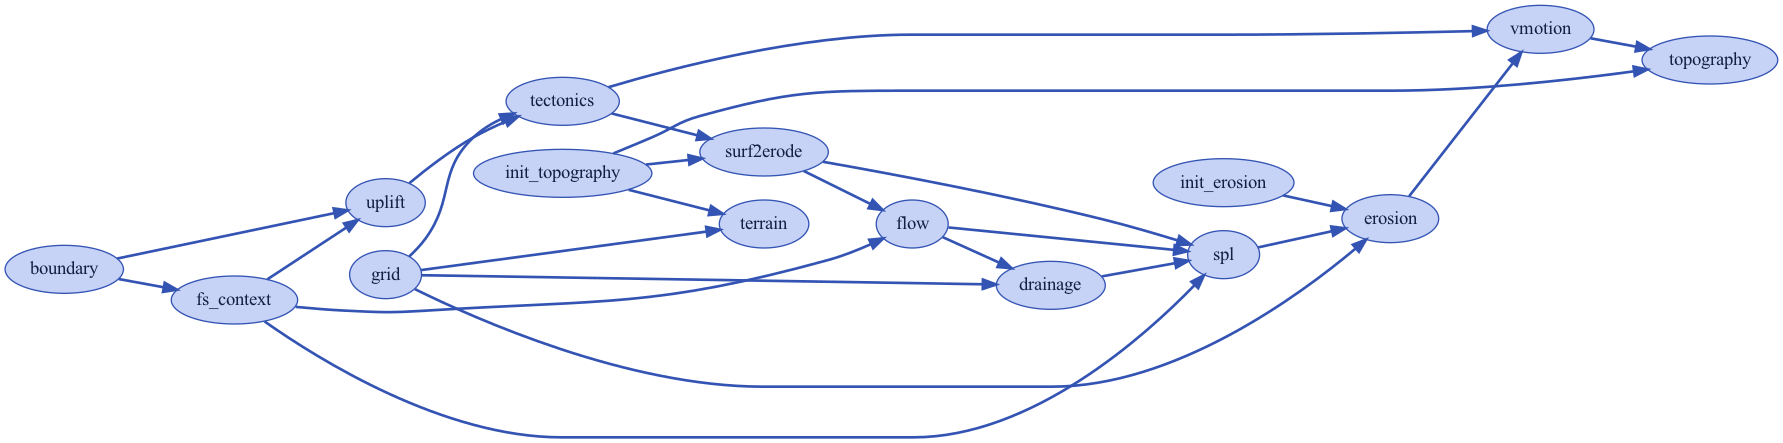

In [5]:
model.visualize()
#model.visualize(show_inputs = True)
#model.visualize(show_variables = True)

In [6]:
basic_model.topography

<SurfaceTopography 'topography' (xsimlab process)>
Variables:
    elevation      [inout] ('y', 'x') surface topography elevation
    motion_upward     [in] <--- vmotion.surface_upward
Simulation stages:
    finalize_step

### Model set-up

After looking at what is inside, we can run the model. For that, we need to set it up. We will now do a basic setup with neutral values. Before setting up the model, some pre-determined parameters are usually needed.

In [7]:
tf = 10e6
U = 1e-3

nx = 101
ny = 51
xl = 10e3
yl = 5e3

x,y = np.meshgrid(np.linspace(0,xl,nx),np.linspace(0,yl,ny))
k = 0.1e-5+x/xl*1e-5

In [8]:
# %create_setup model -d -v
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={'time': np.linspace(0,tf,101),
           "out": np.linspace(0, tf, 51)},
    master_clock="time",
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny, nx],
        # total grid length in (y, x)
        'grid__length': [yl, xl],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': U,
        # random seed
        'init_topography__seed': None, #we can also have an initial topography
        # bedrock channel incision coefficient
        'spl__k_coef': xr.DataArray(k, dims = ('y','x')),
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
    },
    output_vars={'topography__elevation':'time',
                'drainage__area': 'time'}
)


*clocks*: It is as it says, our way to create time. We can have multiple clocks, but we need one "master clock" on which the model will run. (i.e., coordinates for the simulation time steps and variable snapshot saving) and output variables.

*outputs*: "out_vars" are the parameters we want to work with. They are defined on the .py file, so we have to call onto them while creating our model. You can have  

*ds_in* and *ds_out*: 

What will we use now? ds_in!

In [9]:
ds_in

<xarray.Dataset>
Dimensions:                (time: 101, out: 51, shape_yx: 2, y: 51, x: 101)
Coordinates:
  * time                   (time) float64 0.0 1e+05 2e+05 ... 9.9e+06 1e+07
  * out                    (out) float64 0.0 2e+05 4e+05 ... 9.8e+06 1e+07
Dimensions without coordinates: shape_yx, y, x
Data variables:
    grid__shape            (shape_yx) int64 51 101
    grid__length           (shape_yx) float64 5e+03 1e+04
    boundary__status       <U11 'fixed_value'
    uplift__rate           float64 0.001
    init_topography__seed  object None
    spl__k_coef            (y, x) float64 1e-06 1.1e-06 ... 1.09e-05 1.1e-05
    spl__area_exp          float64 0.4
    spl__slope_exp         int64 1

ds_in is what we call every array included in the values we put into the model. To how they work and what they mean, we have to examine the table.

ds_in, take yout time, put graphs, make a plot of clock...

In [10]:
#zarr saves your run into a zarr file in your directory. It is better if your computer does not have a lot of RAM memory (like 16 GB) to leave it clean.

import zarr

zgroup = zarr.group("Output1.zarr", overwrite=True)

with model, xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(store=zgroup)
    
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                (border: 4, time: 101, y: 51, x: 101, shape_yx: 2,
                            out: 51)
Coordinates:
  * border                 (border) object 'left' 'right' 'top' 'bottom'
  * out                    (out) float64 0.0 2e+05 4e+05 ... 9.8e+06 1e+07
  * time                   (time) float64 0.0 1e+05 2e+05 ... 9.9e+06 1e+07
  * x                      (x) float64 0.0 100.0 200.0 ... 9.8e+03 9.9e+03 1e+04
  * y                      (y) float64 0.0 100.0 200.0 ... 4.8e+03 4.9e+03 5e+03
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status       <U11 'fixed_value'
    drainage__area         (time, y, x) float64 dask.array<chunksize=(51, 26, 51), meta=np.ndarray>
    grid__length           (shape_yx) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    grid__shape            (shape_yx) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    init_topography__seed  float64 nan
    spl__area_exp          float64 0.4
    spl__k_coef            (y, x) float64 dask.array<chunksize=(51, 101), meta=np.ndarray>
    spl__slope_exp         int64 1
    topography__elevation  (time, y, x) float64 dask.array<chunksize=(51, 26, 51), meta=np.ndarray>
    uplift__rate           float64 0.001

In [11]:
ds_out.topography__elevation
#if you want even more details add a ? at the end

<xarray.DataArray 'topography__elevation' (time: 101, y: 51, x: 101)>
dask.array<open_dataset-9b77762ded31e168cf34531167eae2cftopography__elevation, shape=(101, 51, 101), dtype=float64, chunksize=(51, 26, 51), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 1e+05 2e+05 3e+05 ... 9.8e+06 9.9e+06 1e+07
  * x        (x) float64 0.0 100.0 200.0 300.0 ... 9.7e+03 9.8e+03 9.9e+03 1e+04
  * y        (y) float64 0.0 100.0 200.0 300.0 ... 4.7e+03 4.8e+03 4.9e+03 5e+03
Attributes:
    description:  surface topography elevation

Finding specific values:

In [12]:
a = ds_out.topography__elevation.values.min()
b = ds_out.topography__elevation.values.mean()
c = ds_out.topography__elevation.values.max()
print(a, b, c)

0.0002778460867230992 1461.877110573092 7428.0094698018065


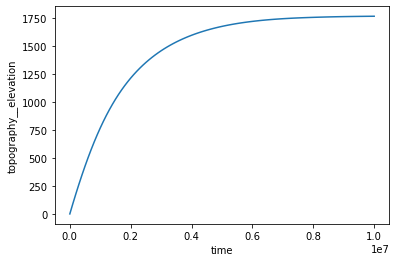

In [13]:
ds_out.topography__elevation.mean(('x','y')).plot()

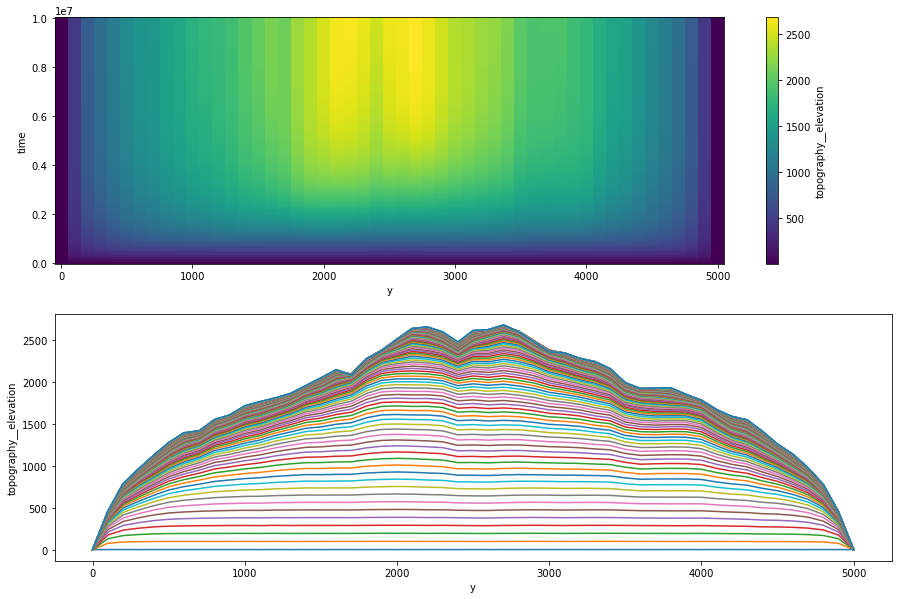

In [14]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

ds_out.topography__elevation.mean('x').plot(ax = ax[0], x = 'y');
ds_out.topography__elevation.mean('x').plot.line(ax = ax[1], x = 'y', add_legend = False);

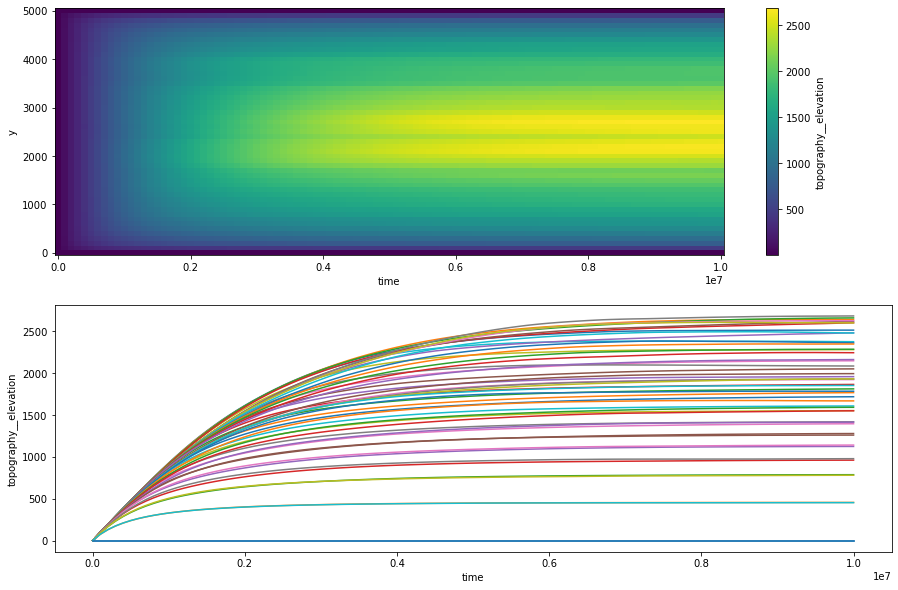

In [15]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

ds_out.topography__elevation.mean('x').plot(ax = ax[0], x = 'time');
ds_out.topography__elevation.mean('x').plot.line(ax = ax[1], x = 'time', add_legend = False);

**Selecting only one scenario**: It is possible to select only one, or specific time steps or scenarios and not have all at the same time. For this, .sel and .isel are very useful.

#### Very useful tools: .sel and .isel

These two features are indexing options. You will use both depending on your needs and preferences.

- isel: Returns a new dataset with each array indexed along the specified dimension(s). For example, you want the middle point in an array of 50 numbers in dimension x: .isel(x = 24)

- sel: Return a new DataArray whose data is given by selecting index labels along the specified dimension(s). For the same example, you will need the label of that point, which you have previously defined: .sel(x = middle).
*Opposed to .isel, we put labels as indexers instead of numbers. It is powerful, because if you are not sure what number you are searching for, indexing through labels helps you understand data best. Be careful as usually, you will not be able to interchange both writing systems.*

##### Examples

In [16]:
ds_out.time

<xarray.DataArray 'time' (time: 101)>
array([       0.,   100000.,   200000.,   300000.,   400000.,   500000.,
         600000.,   700000.,   800000.,   900000.,  1000000.,  1100000.,
        1200000.,  1300000.,  1400000.,  1500000.,  1600000.,  1700000.,
        1800000.,  1900000.,  2000000.,  2100000.,  2200000.,  2300000.,
        2400000.,  2500000.,  2600000.,  2700000.,  2800000.,  2900000.,
        3000000.,  3100000.,  3200000.,  3300000.,  3400000.,  3500000.,
        3600000.,  3700000.,  3800000.,  3900000.,  4000000.,  4100000.,
        4200000.,  4300000.,  4400000.,  4500000.,  4600000.,  4700000.,
        4800000.,  4900000.,  5000000.,  5100000.,  5200000.,  5300000.,
        5400000.,  5500000.,  5600000.,  5700000.,  5800000.,  5900000.,
        6000000.,  6100000.,  6200000.,  6300000.,  6400000.,  6500000.,
        6600000.,  6700000.,  6800000.,  6900000.,  7000000.,  7100000.,
        7200000.,  7300000.,  7400000.,  7500000.,  7600000.,  7700000.,
        7800000.,  7900000.,  8000000.,  8100000.,  8200000.,  8300000.,
        8400000.,  8500000.,  8600000.,  8700000.,  8800000.,  8900000.,
        9000000.,  9100000.,  9200000.,  9300000.,  9400000.,  9500000.,
        9600000.,  9700000.,  9800000.,  9900000., 10000000.])
Coordinates:
  * time     (time) float64 0.0 1e+05 2e+05 3e+05 ... 9.8e+06 9.9e+06 1e+07
Attributes:
    __xsimlab_master_clock__:  1
    __xsimlab_output_clock__:  1

In [17]:
ds_out.time.isel(time = 50)

<xarray.DataArray 'time' ()>
array(5000000.)
Coordinates:
    time     float64 5e+06
Attributes:
    __xsimlab_master_clock__:  1
    __xsimlab_output_clock__:  1

In [18]:
ds_out.time.sel(time = 5e+06)

<xarray.DataArray 'time' ()>
array(5000000.)
Coordinates:
    time     float64 5e+06
Attributes:
    __xsimlab_master_clock__:  1
    __xsimlab_output_clock__:  1

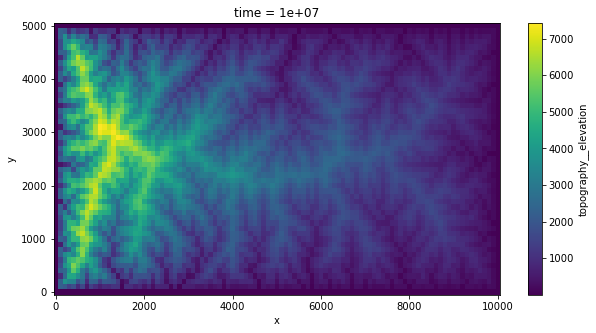

In [19]:
ds_out.topography__elevation.isel(time=-1).plot(size=5, aspect=2)

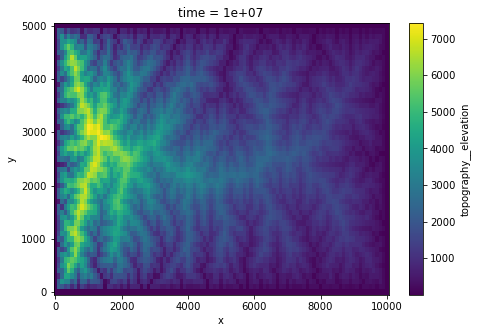

In [20]:
ds_out.topography__elevation.sel(time=10e6).plot(size=5)#, aspect=2)

You can also select a "slice" of our map using sel with the command below:

In [21]:
# slices inbetween x and y min and max values. 
#We have a smaller array in between the x an y min and max values
ds_out.topography__elevation.sel(x=slice(4000,6000), y=slice(2000,4000))

<xarray.DataArray 'topography__elevation' (time: 101, y: 21, x: 21)>
dask.array<getitem, shape=(101, 21, 21), dtype=float64, chunksize=(51, 15, 11), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 1e+05 2e+05 3e+05 ... 9.8e+06 9.9e+06 1e+07
  * x        (x) float64 4e+03 4.1e+03 4.2e+03 4.3e+03 ... 5.8e+03 5.9e+03 6e+03
  * y        (y) float64 2e+03 2.1e+03 2.2e+03 2.3e+03 ... 3.8e+03 3.9e+03 4e+03
Attributes:
    description:  surface topography elevation

And plot it!

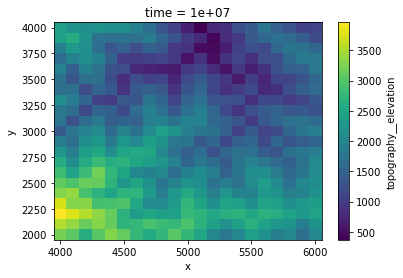

In [22]:
(ds_out.topography__elevation.sel(x=slice(4000,6000), y=slice(2000,4000))).sel(time = 10e6).plot()

Last but not least: dot-chains! As mentioned in the introduction to Xarray, dots are a powerful tool to create complicated results in one line. You can attribute an attribute of an attribute etc...

Example:

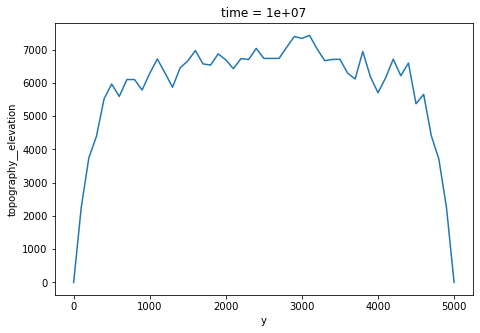

In [23]:
ds_out.topography__elevation.max('x').isel(time=-1).plot(size=5)#, aspect=2)

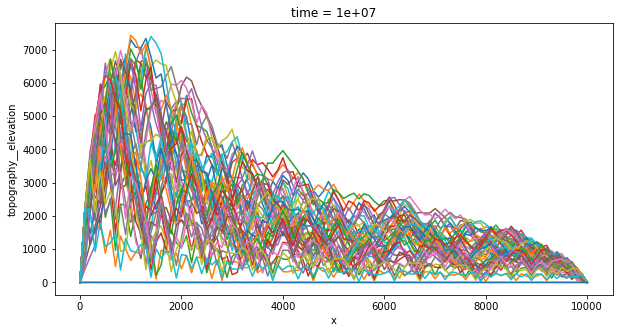

In [24]:
ds_out.topography__elevation.isel(time=-1).plot.line(x = 'x', size=5, aspect=2, add_legend = False);

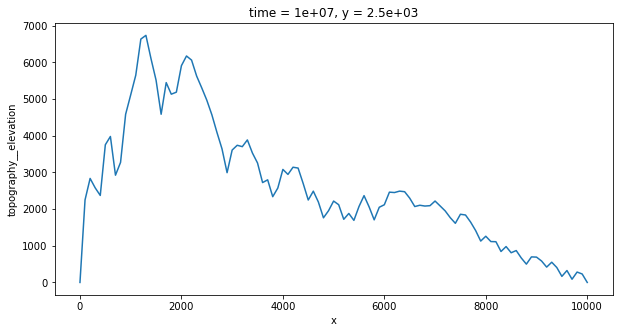

In [25]:
ds_out.topography__elevation.isel(time=-1).isel(y=25).plot.line(x = 'x', size=5, aspect=2);

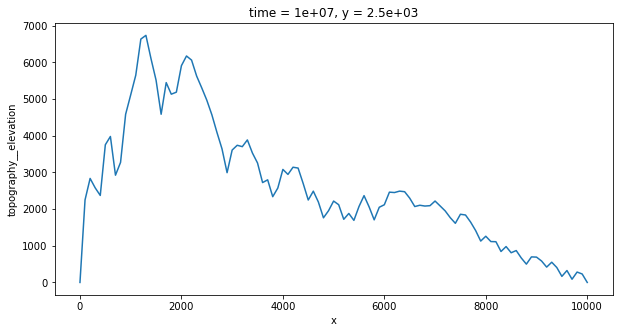

In [26]:
ds_out.topography__elevation.isel(time=-1).isel(y=25).plot.line(x = 'x', size=5, aspect=2);

## Going further: Some tips and tricks about mechanics

### .differentiate and .integrate: useful derivative and integration tools

It automatically uses the derivative/integrates of our functions/arrays. An example of it will be shown while plotting fluxes during the Regolith part.

### Dask

A library for parallel computing in Python. For more information, go read the docs https://docs.dask.org/en/stable/. Dask is a box set where you pur your arrays in. You basically put boxes into bigger boxes for better comprehension and organisation when needed.

### Zarr

It saves datasets to saving what is called a "zarr group". If we divided our datasets into dask boxes, zarr will save data under these boxes. If not, zarr will determine automatically how to store the data sets (it will set its own boxes). 

For more information: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.to_zarr.html or https://zarr.readthedocs.io/en/stable/.

### Boundary conditions in Fastscape

Boundaries in Fastscape are the boundaries of the model, which means each side of our grid. There are 3 options for boundary conditions:
- fixed_value: at least one border need to be fixed. It is the minimum needed to make the model usable. The boundary is closed and nothing happens across it.
- looped: this means that your border is not "finished" and starts again on the adjacent side. When we loop, we must loop two opposing borders for it to work.
- core: The boundary is open, which means, that our landscape continues across the boundary. Small note - if two opposing boundaries are defined as cores, the borders will have periodic conditions due to some Fastscape properties. 


### Batch

With XarraySimlab, it is possible to make multiple runs at the same time, and will be saved as one data array. It is very useful for parameter analysis and comparing scenarios. You can run batches while changing only one parameter, or you can change multiple parameters, and scenarios will run like matrices, so every possible combination will be made.

However, this also means that with a lot of different values for parameters, the run will take longer to finish. Take into account that the time will increase exponentially: if you have 1 parameter with 4 values, then you run 4 models. If you have 2 parameters with 4 values, you already have 16 runs. If you add more, you can increase your model runs into three or four digits very fast (ex: $7*7*7*7$...).

### Movie making

It is a fun and intesresting way to show results. Usually, it also helps understand behaviours that cannot be depicted as static plots. There are multiple ways to do videos/movies of our work, here two possibilities. 
- One consists of using TopoVizd3D, where we can play with the figure, make it run in loop, stop at certain points and analyse our results interactively.
- The second is less glamourous: saving multiple figures into one file and while using a movie maker app, create an image sequence which, ultimately, results in a video.
Both will be adressed in the next notebooks.

# Fastscape documentation

A small example about where and how to find informations concerning Fastscape models and how to use it. Fastscape has a GitHub, documentation, forums and is updated frequently. You will find information about it under https://fastscape.readthedocs.io/en/latest/index.html.

When looking for models, this is where to go: https://fastscape.readthedocs.io/en/latest/models.html. You will find the bootstrap model (basic minimun for LEM), basic model (standart model), sediment model and marine models. New models can be added too.  All these have different set of equations they are based on, which means that they are put together with different processes. You can check for processes here: https://fastscape.readthedocs.io/en/latest/processes.html.

When you want to know more about a process you use, it interesting to check out what is inside the process. There are multiple ways, for example looking at the .py file, or you can click on the processes in the documentation. For exemple, if you want to know more about the processes "SurfaceTopography" which is used in the basic model you go here: https://fastscape.readthedocs.io/en/latest/_api_generated/fastscape.processes.SurfaceTopography.html#fastscape.processes.SurfaceTopography

![OP](./assets/tbc.png)